In [1]:
library(Seurat)
library(SeuratDisk)
library(NMF)
library(ggalluvial)
library(ComplexHeatmap)
library(CellChat)
library(patchwork)
library(graphics)
library(Matrix)
library(circlize)
library(colorspace)
library(pracma)
library(glue)

options(stringsAsFactors = FALSE, repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 300)

source("../Scripts/A-Sender_Receiver_Chord.r")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')

Loading required package: ggplot2

Loading required package: grid

ComplexHeatmap version 2.15.4
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correla

# Parameters

In [3]:
# for plotting figC, differential network
disease = "AD"
project = "AD_Paper"

type <- "truncatedMean"
trim <- 0.05

In [4]:
cellchat.CT <- readRDS(file = glue("/extra/zhanglab0/CommonData/AMP-AD/Obj-CellChat/subclass_cellchat_control.rds"))
cellchat.AD <- readRDS(file = glue("/extra/zhanglab0/CommonData/AMP-AD/Obj-CellChat/subclass_cellchat_alz.rds"))

In [5]:
cellchat.CT <- updateCellChat(cellchat.CT)
cellchat.AD <- updateCellChat(cellchat.AD)

Warning message in updateCellChat(cellchat.CT):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”
Warning message in updateCellChat(cellchat.AD):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`!”


In [6]:
object.list_ADvCON <- list(CON = cellchat.CT, AD = cellchat.AD)
cellchat_ADvCON <- mergeCellChat(object.list_ADvCON, add.names = names(object.list_ADvCON))
print(cellchat_ADvCON)
print(names(object.list_ADvCON))

#object.list_MDDvCON <- list(CT = cellchat.CT, MDD = cellchat.MDD)
#cellchat_MDDvCON <- mergeCellChat(object.list_MDDvCON, add.names = names(object.list_MDDvCON))
#print(cellchat_MDDvCON)
#print(names(object.list_MDDvCON))

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



An object of class CellChat created from a merged object with multiple datasets 
 704 signaling genes.
 51171 cells. 
CellChat analysis of single cell RNA-seq data! 
[1] "CON" "AD" 


In [7]:
#celltype_name = c('Astro', 'Endo', 'MG', 'Oligo', 'OPC', 
#                  'Exc CUX2', 'Exc FEZF2', 'Exc OPRK1', 'Exc RORB', 
#                  'Inh KCNG1', 'Inh LAMP5', 'Inh PVALB', 'Inh SST', 'Inh VIP')

celltype_name = c('Chandelier', 'Lamp5', 'Lamp5 Lhx6', 'Pax6', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'Sst Chodl', 
                  'L2/3 IT', 'L4 IT', 'L5', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 
                  'Astro', 'Endo', 'Oligo', 'OPC', 'VLMC', 'Micro/PVM')

measure = 'weight'

In [8]:
color.use = c(rainbow_hcl(9, c = 100), colorRampPalette(c("red", "orange"))(7), colorRampPalette(c("blue", "green"))(7))
color.use

[1] "#FF7A9E" "#F39525" "#BDAF00" "#59C200" "#00CD8D" "#00CBDA" "#00B7FF"
 [8] "#C890FF" "#FF72EA" "#FF0000" "#FF1B00" "#FF3700" "#FF5200" "#FF6E00"
[15] "#FF8900" "#FFA500" "#0000FF" "#002AD4" "#0055AA" "#007F7F" "#00AA55"
[22] "#00D42A" "#00FF00"

# Code 

In [108]:
direction <- "to"

#Figure 4B
pathways.show      <- "WNT"
receiver <- c('Sncg', 'Pvalb', 'Pax6', 'Lamp5 Lhx6', 'Lamp5', 'L2/3 IT', 'L4 IT', 'L5', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6B')
sender <- c('Endo', 'L6 IT Car3')

#Figure 4C
#pathways.show      <- "CSF"
#receiver <- c('Micro/PVM')
#sender <- c('L6B')

#Figure 4D
#pathways.show      <- "TGFb"
#receiver <- c('Micro/PVM')
#sender <- c('Astro', 'Sncg')

#Figure 4E
#pathways.show      <- "CX3C"
#receiver <- c('Micro/PVM')
#sender <- c('Lamp5 Lhx6', 'Pvalb', 'L2/3 IT', 'L4 IT', 'L5', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6B')

## Cell Type

In [109]:
# get the matrix
obj1 <- object.list_ADvCON[[1]]@net[[measure]]              # CT
obj2 <- object.list_ADvCON[[2]]@net[[measure]]              # DIS
melt_1 <- reshape2::melt(obj1, value.name="count")
melt_2 <- reshape2::melt(obj2, value.name="count")
sum1 <- sum(melt_1$count)
sum2 <- sum(melt_2$count)

# balance
normalization_ADvCON = sum1 / sum2
# normalization = sum(object.list[[1]]@netP$prob) / sum(object.list[[2]]@netP$prob)
net.diff_ADvCON <- obj2 * (normalization_ADvCON) - obj1

# reorder the celltypes
net.diff_ADvCON <- net.diff_ADvCON[celltype_name, celltype_name]

net.diff_ADvCON[setdiff(celltype_name, sender), setdiff(celltype_name, receiver)] <- 0 

#### MDD v CON

## Pathway

In [110]:
# Don't change. Hard-coded
matrix.CT     <- cellchat.CT@netP$prob        # 14 x 14 x 946
matrix.AD     <- cellchat.AD@netP$prob       # 14 x 14 x 943
normalization <- sum(cellchat.CT@net$weight) / sum(cellchat.AD@net$weight)  # CT / AD, obtained from the 14x14 cell type matrix

pathways.show_weight.CT  <- matrix.CT[, , pathways.show]
pathways.show_weight.AD <- matrix.AD[, , pathways.show]
pathways.show_weight.differential <- pathways.show_weight.AD * normalization - pathways.show_weight.CT        # DIS - CON

# reorder the celltypes
pathways.show_weight.differential <- pathways.show_weight.differential[celltype_name, celltype_name]

pathways.show_weight.differential[setdiff(celltype_name, sender), setdiff(celltype_name, receiver)] <- 0 

# # if statement needed for 2D-matrices with only 1 ligand-receptor pair
# if ((length(pathways.show) > 1) & (length(sender_celltypes)) > 1 & (length(receiver_celltypes) > 1)) {
#     pathways.show_weight.CT           <- apply(matrix.CT[sender_celltypes, receiver_celltypes, pathways.show], c(3), sum)
#     pathways.show_weight.DIS          <- apply(matrix.DIS[sender_celltypes, receiver_celltypes, pathways.show], c(3), sum)
#     pathways.show_weight.differential <- pathways.show_weight.DIS * normalization - pathways.show_weight.CT        # DIS - CON
# } else if (length(pathways.show) == 1) {
#     pathways.show_weight.CT           <- sum(matrix.CT[sender_celltypes, receiver_celltypes, pathways.show])
#     pathways.show_weight.DIS          <- sum(matrix.DIS[sender_celltypes, receiver_celltypes, pathways.show])
#     pathways.show_weight.differential <- pathways.show_weight.DIS * normalization - pathways.show_weight.CT        # DIS - CON
# } else if ((length(sender_celltypes)) == 1 || (length(receiver_celltypes) == 1)) {
#     pathways.show_weight.CT           <- apply(matrix.CT[sender_celltypes, receiver_celltypes, pathways.show], c(2), sum)
#     pathways.show_weight.DIS          <- apply(matrix.DIS[sender_celltypes, receiver_celltypes, pathways.show], c(2), sum)
#     pathways.show_weight.differential <- pathways.show_weight.DIS * normalization - pathways.show_weight.CT        # DIS - CON
# }

In [111]:
pathways.show_weight.differential

,Chandelier,Lamp5,Lamp5 Lhx6,Pax6,Pvalb,Sncg,Sst,Vip,Sst Chodl,L2/3 IT,⋯,L6 CT,L6 IT,L6 IT Car3,L6b,Astro,Endo,Oligo,OPC,VLMC,Micro/PVM
Chandelier,0,0.0000000,0.000000000,0.000000000,0.00000000,0.0000000,0,0,0,0.000000000,⋯,0.00000000,0.000000000,0.000000000,0.000000000,0,0,0,0,0,0
Lamp5,0,0.0000000,0.000000000,0.000000000,0.00000000,0.0000000,0,0,0,0.000000000,⋯,0.00000000,0.000000000,0.000000000,0.000000000,0,0,0,0,0,0
Lamp5 Lhx6,0,0.0000000,0.000000000,0.000000000,0.00000000,0.0000000,0,0,0,0.000000000,⋯,0.00000000,0.000000000,0.000000000,0.000000000,0,0,0,0,0,0
Pax6,0,0.0000000,0.000000000,0.000000000,0.00000000,0.0000000,0,0,0,0.000000000,⋯,0.00000000,0.000000000,0.000000000,0.000000000,0,0,0,0,0,0
Pvalb,0,0.0000000,0.000000000,0.000000000,0.00000000,0.0000000,0,0,0,0.000000000,⋯,0.00000000,0.000000000,0.000000000,0.000000000,0,0,0,0,0,0
Sncg,0,0.0000000,0.000000000,0.000000000,0.00000000,0.0000000,0,0,0,0.000000000,⋯,0.00000000,0.000000000,0.000000000,0.000000000,0,0,0,0,0,0
Sst,0,0.0000000,0.000000000,0.000000000,0.00000000,0.0000000,0,0,0,0.000000000,⋯,0.00000000,0.000000000,0.000000000,0.000000000,0,0,0,0,0,0
Vip,0,0.0000000,0.000000000,0.000000000,0.00000000,0.0000000,0,0,0,0.000000000,⋯,0.00000000,0.000000000,0.000000000,0.000000000,0,0,0,0,0,0
Sst Chodl,0,0.0000000,0.000000000,0.000000000,0.00000000,0.0000000,0,0,0,0.000000000,⋯,0.00000000,0.000000000,0.000000000,0.000000000,0,0,0,0,0,0
L2/3 IT,0,0.0000000,0.000000000,0.000000000,0.00000000,0.0000000,0,0,0,0.000000000,⋯,0.00000000,0.000000000,0.000000000,0.000000000,0,0,0,0,0,0


In [112]:
pathways.show

[1] "WNT"

png 
  2

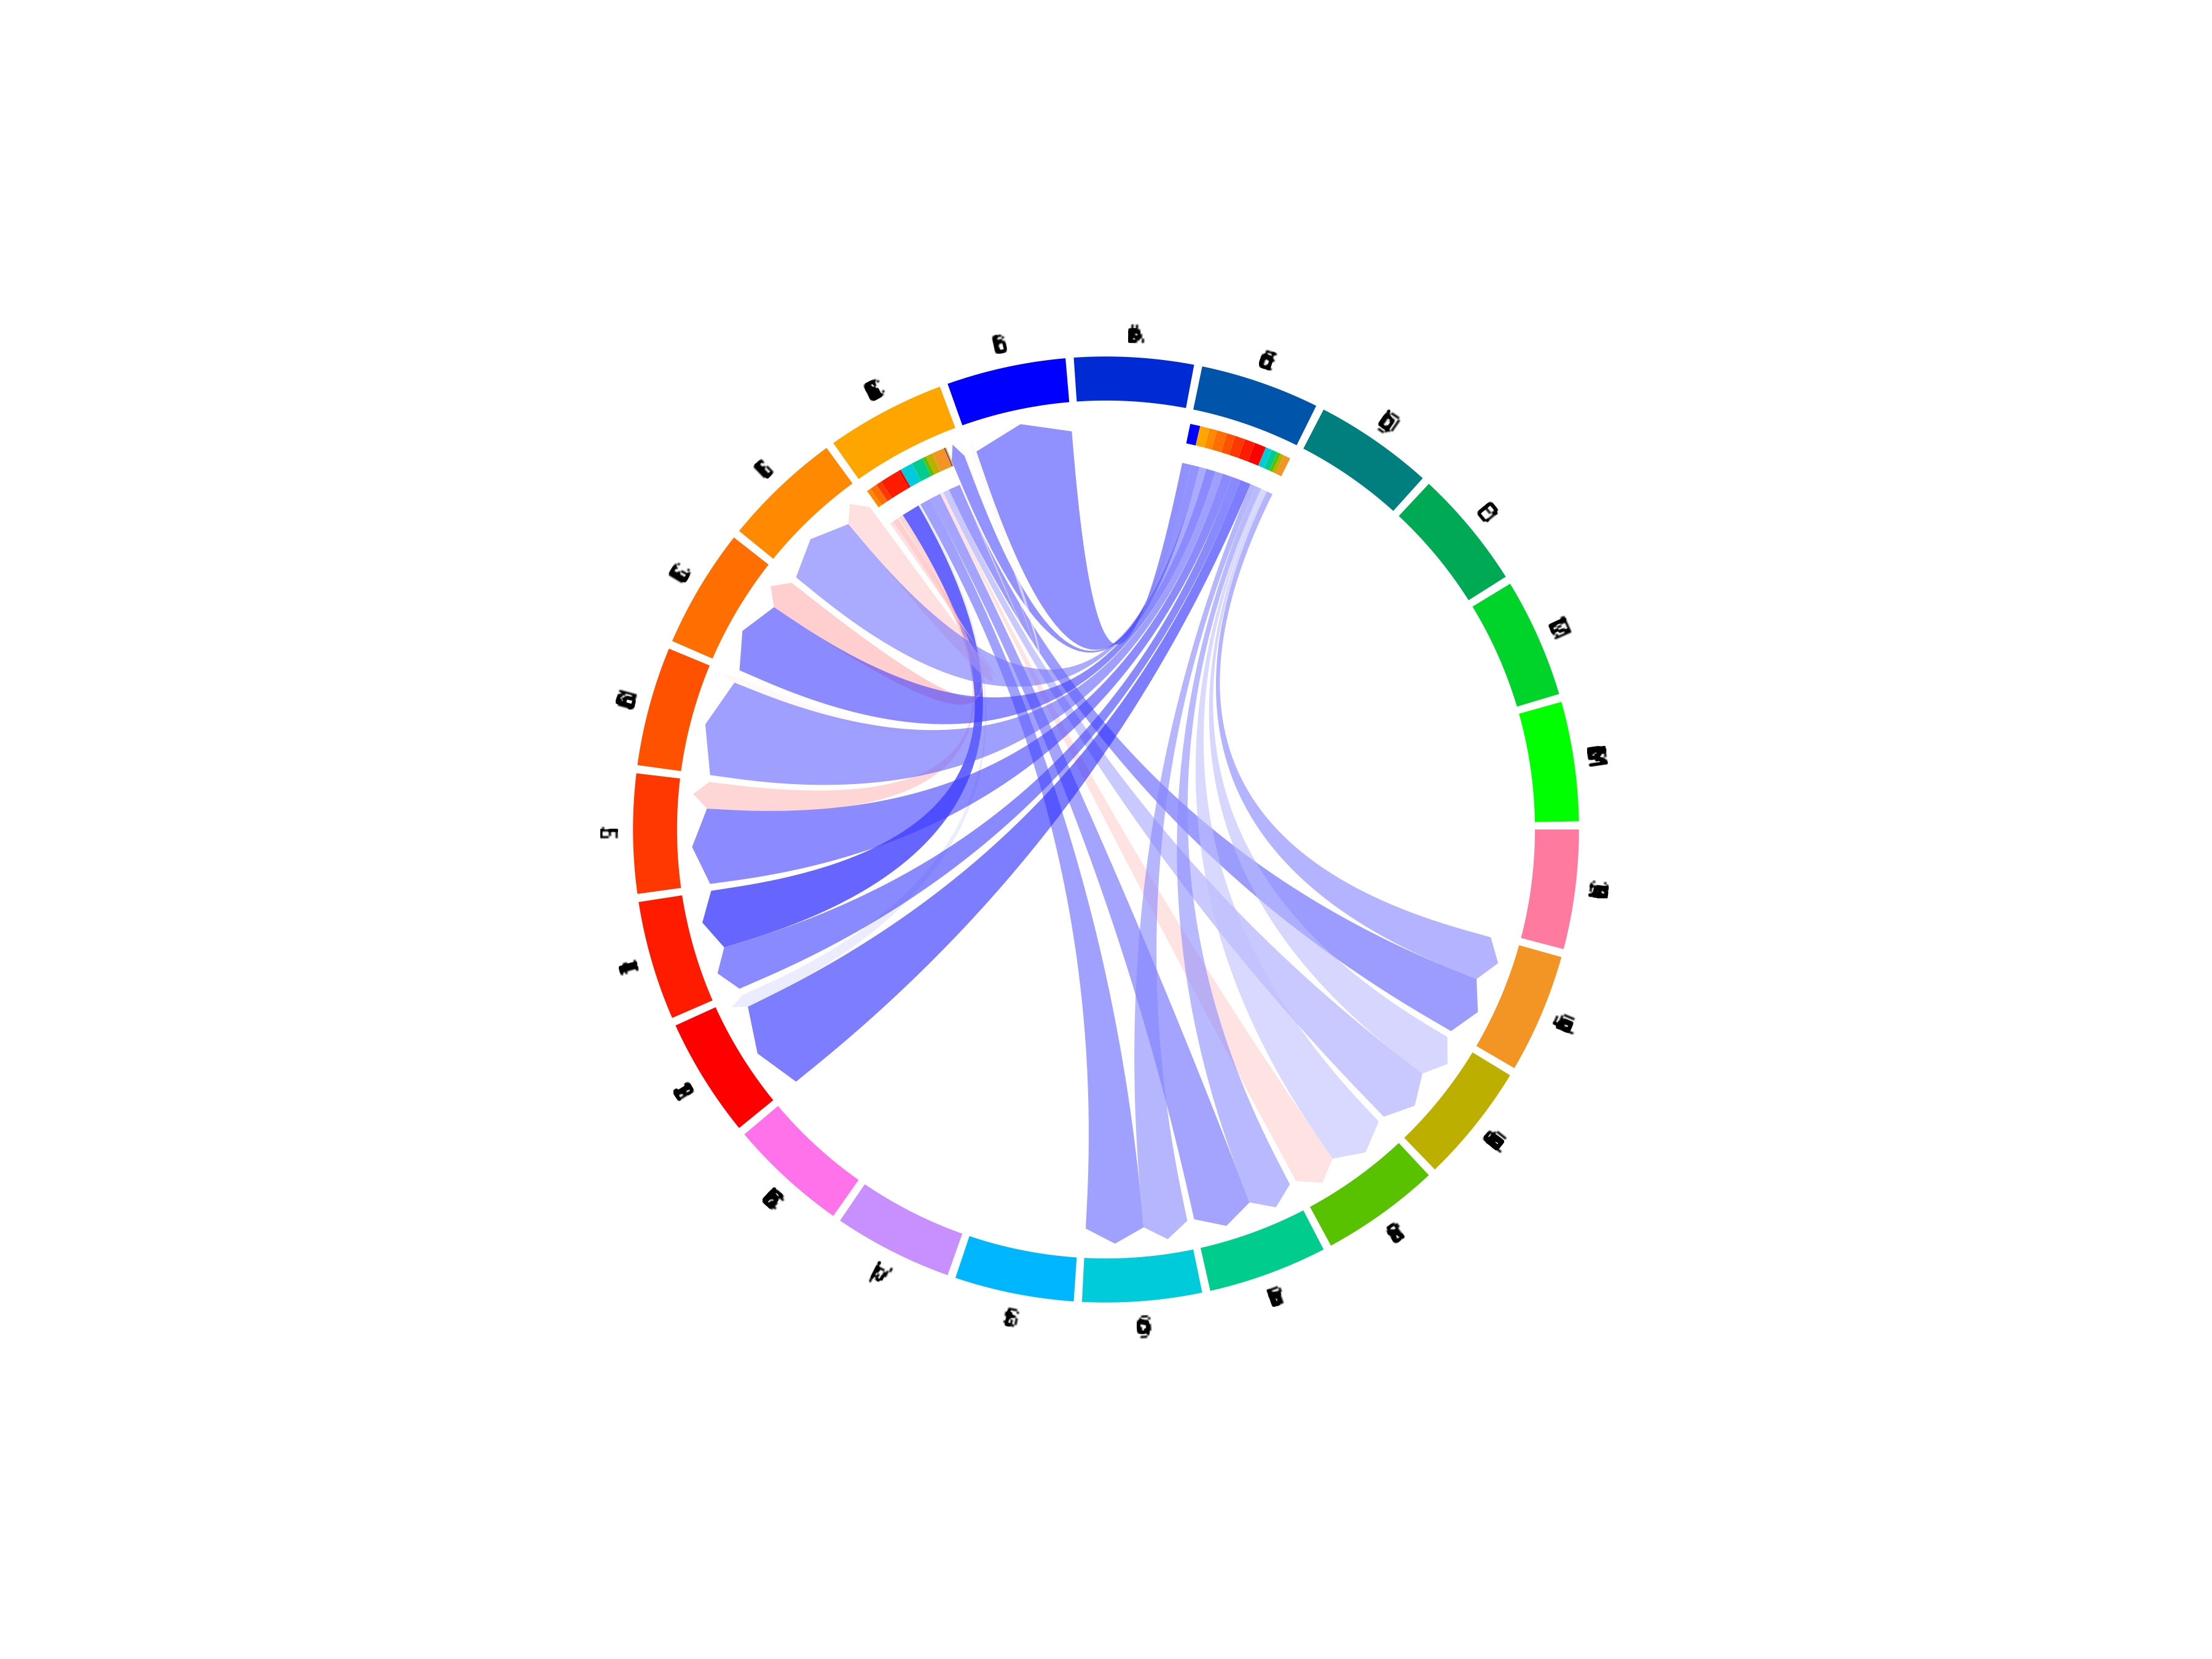

In [113]:
gg2 <- my_netVisual_aggregate2(pathways.show_weight.differential, layout="chord", cell.order=celltype_name, color.use = color.use, 
                               signaling.name = pathways.show)

pdf(file = glue("Figure4B.pdf"), width = 15, height = 15) #pathways.show <- "WNT"
#pdf(file = glue("Figure4C.pdf"), width = 15, height = 15) #pathways.show <- "CSF"
#pdf(file = glue("Figure4D.pdf"), width = 15, height = 15) #pathways.show <- "TGBf"
#pdf(file = glue("Figure4E.pdf"), width = 15, height = 15) #pathways.show <- "CX3C"

print(gg2) 
dev.off()